<div style="text-align: center; margin: 20px 0;">
  <h1 style="color: blue; margin-bottom: 0;">Cockroach Cars Global Dealership</h1><br>
  <h2 style="color: blue; font-style: italic; margin-top: 5px;">"The Only Thing Eventually Consistent Is Your Driving"</h2>
  <img src="./img/RoachCars.png" style="
    width: 100%;
    height: 650px;
    object-fit: cover;
    display: block;
    margin: 0 auto;
  ">
</div>

In [1]:
# Import modules, load SQL Magic and connect to CockroachDB

from wdgts_roach_cars import *

import warnings
import shared_state as s
import sqlalchemy as db

os.environ["TOKENIZERS_PARALLELISM"] = "false"

%load_ext sql
%sql cockroachdb://root@localhost:26257/vectors?sslmode=disable

display(Markdown("""
### <span style='color:green'>We’re now connected to CRDB.</span>  
A distributed SQL database that scales like a dream!!!<br><br>
"""))


### <span style='color:green'>We’re now connected to CRDB.</span>  
A distributed SQL database that scales like a dream!!!<br><br>


---

# Basic Tables Shape Analysis

In [2]:
%%sql WITH row_counts AS (SELECT 'vehicle_details' AS table_name, COUNT(*) AS total_rows FROM vehicle_details
    UNION ALL
    SELECT 'car_image_embeddings' AS table_name, COUNT(*) AS total_rows FROM car_image_embeddings
),
column_counts AS (
    SELECT table_name, COUNT(*) AS total_columns
    FROM information_schema.columns
    WHERE table_name IN ('vehicle_details', 'car_image_embeddings')
    GROUP BY table_name
),
table_stats AS (
    SELECT
        rc.table_name,
        rc.total_rows,
        cc.total_columns,
        CONCAT(rc.total_rows, ' rows and ', cc.total_columns, ' columns') AS table_shape
    FROM row_counts rc
    JOIN column_counts cc ON rc.table_name = cc.table_name
)
SELECT
    'table_name' AS header,
    MAX(CASE WHEN table_name = 'vehicle_details' THEN table_name END) AS vehicle_details,
    MAX(CASE WHEN table_name = 'car_image_embeddings' THEN table_name END) AS car_image_embeddings
FROM table_stats

UNION ALL

SELECT
    'row_count' AS header,
    MAX(CASE WHEN table_name = 'vehicle_details' THEN total_rows::TEXT END),
    MAX(CASE WHEN table_name = 'car_image_embeddings' THEN total_rows::TEXT END)
FROM table_stats

UNION ALL

SELECT
    'column_count' AS header,
    MAX(CASE WHEN table_name = 'vehicle_details' THEN total_columns::TEXT END),
    MAX(CASE WHEN table_name = 'car_image_embeddings' THEN total_columns::TEXT END)
FROM table_stats

UNION ALL

SELECT
    'summary' AS header,
    MAX(CASE WHEN table_name = 'vehicle_details' THEN table_shape END),
    MAX(CASE WHEN table_name = 'car_image_embeddings' THEN table_shape END)
FROM table_stats;



 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
4 rows affected.


[('table_name', 'vehicle_details', 'car_image_embeddings'),
 ('row_count', '3403', '3403'),
 ('column_count', '15', '3'),
 ('summary', '3403 rows and 15 columns', '3403 rows and 3 columns')]

## Shape Data for Effective Visualization

In [3]:
result = %sql SELECT * FROM vehicle_details;                                     
df = result.DataFrame()                                                          # Convert to Pandas DataFrame
df.head()                                                                        # Preview the data

 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
3403 rows affected.


vin        make          model  color registration_date  \
0  0LSZWZS6LH62TEDVW       Tesla        Model S  Black            6/2025   
1  137ZA84351E608367        Audi      e-tron GT                   3/2023   
2  19UUA56603A670980      Toyota  Innova Crysta                   3/2019   
3  19UUA56621A560347  RollsRoyce           Dawn                  12/2021   
4  19UUA56762A436494      Toyota  Innova Crysta                   5/2017   

   year  price_in_usd  power_kw  power_ps  \
0  2025         75650       193       269   
1  2023        157647       150       230   
2  2019         10125       163       289   
3  2021        168639       199       194   
4  2017         12432       177       233   

                     transmission_type fuel_type fuel_consumption_l_100km  \
0  Automated Manual Transmission (AMT)  Electric             6-14.0 L/100   
1                               Manual  Electric           5.0-10.0 L/100   
2                     Torque Converter   Regular             4-10.5 L/100   
3                     Torque Converter    Diesel          15.0-19.0 L/100   
4                               Manual   Premium             4-10.5 L/100   

   fuel_consumption_g_km mileage_in_km offer_description  
0                    169             8                    
1                    143         10786                    
2                    211         13236                    
3                    170          1599                    
4                    178         20430

## Present Visual Insights

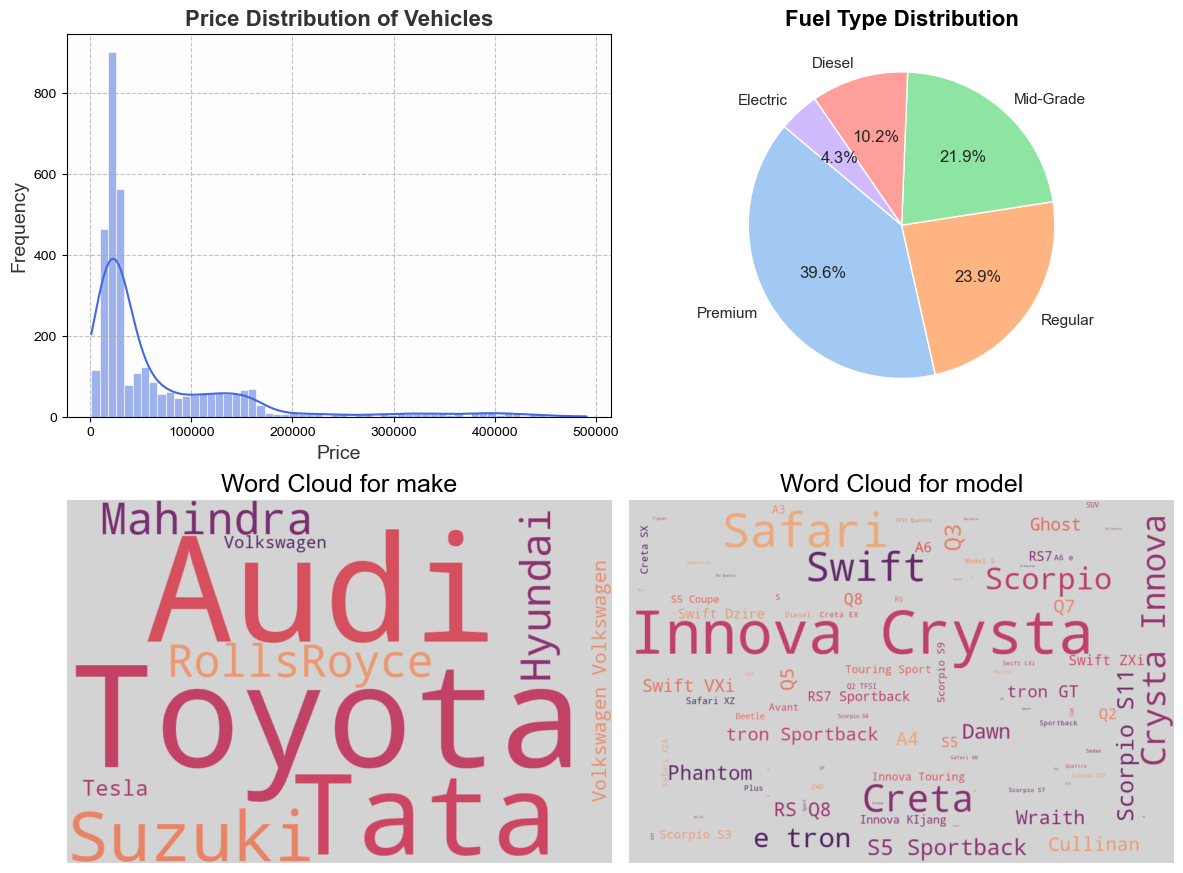

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
sns.set(style="whitegrid")

# ---------- Plot 1: Price Distribution Histogram ----------
hist_color = '#4169E1'
background_color = '#F5F5F5'
grid_color = '#A9A9A9'
text_color = '#333333'

sns.histplot(df['price_in_usd'], kde=True, color=hist_color, ax=axes[0,0])
axes[0,0].set_title('Price Distribution of Vehicles', fontsize=16, fontweight='bold', color=text_color)
axes[0,0].set_xlabel('Price', fontsize=14, color=text_color)
axes[0,0].set_ylabel('Frequency', fontsize=14, color=text_color)
axes[0,0].patch.set_facecolor(background_color)
axes[0,0].patch.set_alpha(0.1)
axes[0,0].grid(True, linestyle='--', alpha=0.7, color=grid_color)

# ---------- Plot 2: Fuel Type Pie Chart ----------
counts = df['fuel_type'].value_counts()
labels = counts.index
sizes = counts.values
color_palette = sns.color_palette("pastel")[:len(labels)]

axes[0,1].pie(
    sizes,
    labels=labels,
    colors=color_palette,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
axes[0,1].set_title('Fuel Type Distribution', fontsize=16, fontweight='bold')

# ---------- Plot 3 & 4: Word Clouds for 'make' and 'model' ----------
cat_features_word = ['make', 'model']
palettes = 'flare'

for ax, feature in zip(axes[1], cat_features_word):
    text = ' '.join(df[feature].astype(str).values)
    wordcloud = WordCloud(
        width=900,
        height=600,
        background_color='lightgray',
        colormap=palettes
    ).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {feature}', fontsize=18)

plt.tight_layout()
plt.show()


---

## Hierarchical K-means Tree

  <img src="./img/k-means-tree-powering-cspann-cockroachdb-vector-indexing.png" width="600" height="800" >

---

##  Show the vector space Visually

#### Execute the query and store the result in a variable

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import ast

display(Markdown("""
<ul>
  <li><span style='color:green; font-weight:bold;'>Retrieve unique car makes and fetch car image embeddings.</span></li>
  <li><span style='color:green; font-weight:bold;'>Uses KMeans clustering to group vector embeddings (reduced to 3D) into clusters—one for each car make in category_list.</span></li>
  <li><span style='color:green; font-weight:bold;'>Create a 3D scatter plot with points colored by cluster and red markers showing the center of each group.</span></li>
</ul>

<br>
"""))
# Execute the query and store the result in a variable
result = %sql SELECT distinct(make) FROM vehicle_details;

# Convert the result to a list (e.g., a list of values or tuples)
# If you want a flat list of category_desc values:
category_list = [row[0] for row in result]

# --- SQL to retrieve 5,000 embeddings ---
sql_qry = """
SELECT embedding
FROM car_image_embeddings 
LIMIT 5000
;
"""

# Execute the query (assuming %sql is available in Jupyter)
results = %sql $sql_qry
vec_df = pd.DataFrame(results)

# --- Convert string representations to real vectors ---
vec_df['embedding'] = vec_df['embedding'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# --- Stack into a matrix and scale ---
embeddings = np.vstack(vec_df['embedding'].values)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# --- Reduce to 3D with PCA ---
pca = PCA(n_components=3)  # keeping 11 for broader analysis, will use first 3 for plotting
reduced = pca.fit_transform(embeddings_scaled)
explained_var = pca.explained_variance_ratio_ * 100

# --- Apply KMeans clustering ---
n_clusters = len(category_list)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(reduced)
centroids = kmeans.cluster_centers_

# --- 3D Scatter Plot of Points, colored by cluster label ---
fig = go.Figure(data=[go.Scatter3d(
    x=reduced[:, 0],
    y=reduced[:, 1],
    z=reduced[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=labels,
        colorscale='Viridis',
        colorbar=dict(
            title='Cluster',
            x=0.5,
            xanchor='center',
            orientation='h',
            thickness=15,
            len=0.5
        ),
        opacity=0.8
    ),
    name='Embeddings',
    showlegend=False
)])

# --- Add each cluster centroid to the plot ---
centroid_names = category_list
for i, c in enumerate(centroids):
    fig.add_trace(go.Scatter3d(
        x=[c[0]],
        y=[c[1]],
        z=[c[2]],
        mode='markers+text',
        marker=dict(size=10, color='red', symbol='diamond'),
        text=[centroid_names[i]],  # Use custom name
        textposition='top center',
        showlegend=False
    ))

# --- Final layout settings ---
fig.update_layout(
    title='3D Projection of Vector Embeddings Using Principal Component Analysis (PCA)',
    width=1200,
    height=1000,
    margin=dict(l=100, r=100, b=120, t=100),
    scene=dict(
        xaxis_title=f'Principal Comp 1 ({explained_var[0]:.2f}%)',
        yaxis_title=f'Principal Comp 2 ({explained_var[1]:.2f}%)',
        zaxis_title=f'Principal Comp 3 ({explained_var[2]:.2f}%)'
    )
)

fig.show()



<ul>
  <li><span style='color:green; font-weight:bold;'>Retrieve unique car makes and fetch car image embeddings.</span></li>
  <li><span style='color:green; font-weight:bold;'>Uses KMeans clustering to group vector embeddings (reduced to 3D) into clusters—one for each car make in category_list.</span></li>
  <li><span style='color:green; font-weight:bold;'>Create a 3D scatter plot with points colored by cluster and red markers showing the center of each group.</span></li>
</ul>

<br>


 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
9 rows affected.
 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
3403 rows affected.


---

<div style="display: flex; align-items: center;">
  <img src="./img/roach_cars.png" width="290" style="margin-right: 60px;">
  <div style="text-items: center;">
      <p style="font-size: 24px; color: blue; font-family:'Courier New'"> <strong><i>"Because every car should commit without rolling back"</i></strong> 
      <br>
      <p style="font-size: 18px;">
        With vector search built into CockroachDB, customers can upload a picture of their dream car, and the platform can match it to real inventory.
        No third-party AI engine. No external embedding service. All handled within CockroachDB.<br><br>
        <i>"One customer pasted in a photo from Fast and Furious... and bought a Nissan Skyline in 2 clicks."</i><br><br>
        Rochie Smith - Senior Sales Representative.
      </p>  
  </div>
</div>

---

## Copy Image from Clipboard


In [8]:
# Get Image from Clipboard

display(Markdown("""#### <span style='color:green;'> <br>Copy an image to your clipboard and then click the <span style='color:black;'>**Get Image From Clipboard**</span> button to display it here.<br></span>"""))

form_01

#### <span style='color:green;'> <br>Copy an image to your clipboard and then click the <span style='color:black;'>**Get Image From Clipboard**</span> button to display it here.<br></span>

In [10]:
# Select number of cars and price range.

display(Markdown("""#### <span style='color:green;'> <br>Select number of cars and price range<br></span>"""))

form_02

#### <span style='color:green;'> <br>Select number of cars and price range<br></span>

## Execute the similarity search

#### Helps you build intelligent, real-time applications without adding architectural complexity. 

#### In CockroachDB, the Euclidean distance between two vectors is calculated using the <-> operator.
<br>


```sql 
SELECT vd.vin
     , fullpath
     , make AS "Make"
     , model AS "Model"
     , "year" AS "Year"
     , price_in_usd AS "Price"
     , (embedding <-> '[0.09781230986118317, 0.7036852836608887, -0.4736102521419525, ...]') AS "Similarity Score"
     , ROUND(100 / (1 + (embedding <-> '[0.09781230986118317, 0.7036852836608887, -0.4736102521419525, ...]')), 2) AS "Closeness"
FROM car_image_embeddings ci JOIN vehicle_details vd on ci.vin = vd.vin
WHERE price_in_usd between 35000 and 69000
ORDER BY embedding <-> '[0.09781230986118317, 0.7036852836608887, -0.4736102521419525, ...]'
LIMIT 10
;



 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
10 rows affected.


#### <span style='color:green;'> <br>Query executed successfully!!!.</span><br>


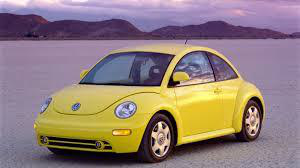


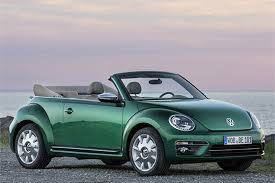


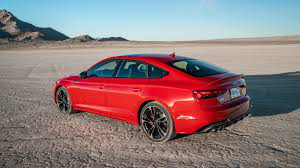


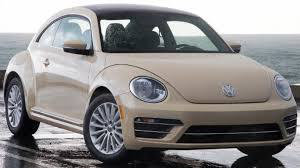


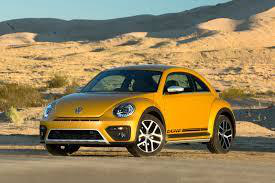


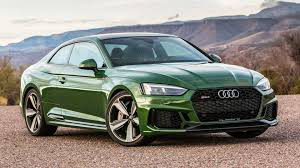


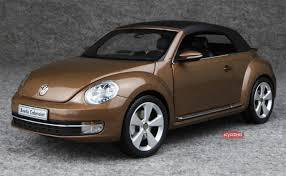


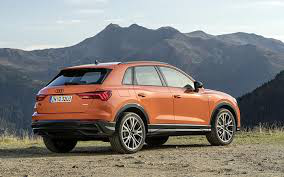


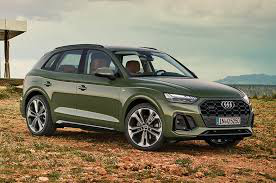


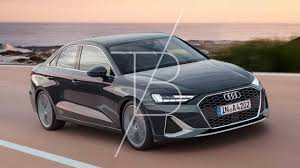

In [17]:
sql_qry = """
SELECT
  vd.vin,
  fullpath,
  make AS "Make",
  model AS "Model",
  "year" AS "Year",
  price_in_usd AS "Price",
  (embedding <-> '{}') AS "Similarity Score",
  ROUND(100 * (1 - (embedding <-> '{}')), 2) AS "Closeness Percent"
FROM car_image_embeddings ci
JOIN vehicle_details vd ON ci.vin = vd.vin
WHERE price_in_usd BETWEEN {} AND {}
ORDER BY embedding <-> '{}'
LIMIT {};
""".format(
    s.qry_embedding,     # for Similarity Score
    s.qry_embedding,     # for Closeness Percent
    int_range.value[0] * 1000,
    int_range.value[1] * 1000,
    s.qry_embedding,     # for ORDER BY
    sldr_result.value
)

sql_qry1 = """
SELECT vd.vin
     , fullpath
     , make AS "Make"
     , model AS "Model"
     , "year" AS "Year"
     , price_in_usd AS "Price"
     , (embedding <-> '{}') AS "Similarity Score"
     , ROUND(100 / (1 + (embedding <-> '{}')), 2) AS "Closeness "
FROM car_image_embeddings ci JOIN vehicle_details vd on ci.vin = vd.vin
WHERE price_in_usd between {} and {}
ORDER BY embedding <-> '{}'
LIMIT {}
;
""".format(s.qry_embedding, s.qry_embedding, int_range.value[0] * 1000, int_range.value[1] * 1000, s.qry_embedding, sldr_result.value )

# Execute euclidean distance search

# Use a Relative Score Instead to show relative closeness by comparing to max or threshold:

# Show only first 5 elements of the vector with ellipsis
vector_preview = s.qry_embedding[:3]
vector_str = str(vector_preview)[:-1] + ', ...]'
display_qry = """
SELECT vd.vin
     , fullpath
     , make AS "Make"
     , model AS "Model"
     , "year" AS "Year"
     , price_in_usd AS "Price"
     , (embedding <-> '{}') AS "Similarity Score"
     , ROUND(100 / (1 + (embedding <-> '{}')), 2) AS "Closeness"
FROM car_image_embeddings ci JOIN vehicle_details vd on ci.vin = vd.vin
WHERE price_in_usd between {} and {}
ORDER BY embedding <-> '{}'
LIMIT {}
;
""".format(vector_str, vector_str, int_range.value[0] * 1000, int_range.value[1] * 1000, vector_str, sldr_result.value )

display(Markdown(f"""
```sql {display_qry}
"""))
try:
    result = %sql $sql_qry
    display(Markdown("""#### <span style='color:green;'> <br>Query executed successfully!!!.</span><br>"""))
    display_result(result)
except Exception as e:
    display(Markdown(f"""<span style='color:red;'> <br> Query failed: {e} </span><br>"""))

---
# Back Office Operations

## Add New Vehicle Image Embedding and Details


In [13]:
# Store the image

display(Markdown("""#### <span style='color:green;'> <br>Add a vehicle image with embeddings and metadata.<br></span>"""))

form_03

#### <span style='color:green;'> <br>Add a vehicle image with embeddings and metadata.<br></span>

---

## Validate the data that has been captured

In [14]:
vector = s.qry_embedding

display(Markdown("""#### <span style='color:green;'> <br>Preview records to insert into CockroachDB.<br></span>"""))
if not s.filename:
    s.filename = f"AICA: You forgot to save the image!"

if vector:
    vector_preview = f"[{vector[0]:.4f}, {vector[1]:.4f}, ..., {vector[-1]:.4f}]"
    data = [(s.vin, s.filename, vector_preview)]
    df_embeddings = pd.DataFrame(
        data
      , columns = ['VIN', 'Image Full Path', 'Embedding']
    )
    display(Markdown("#### Image Embedding Preview"))
    display(df_embeddings)
else:
    print("No Image Uploaded")

# Print all values nicely 
data = [(s.vin, txt_make.value, txt_model.value, txt_color.value, get_random_registration(int_year.value), int_year.value, int_price_usd.value
        , get_random_pwrkw(), get_random_pwrps(), dd_trans.value, dd_fuel.value, get_random_L100(txt_make.value, txt_model.value), get_random_gkm(), int_milage.value, '')]
df_details = pd.DataFrame(
    data
  , columns = s.detail_columns
)
df_details.reset_index(drop=True, inplace=True)
display(Markdown("#### Vehicle Details Preview"))
display(df_details)

#### <span style='color:green;'> <br>Preview records to insert into CockroachDB.<br></span>

#### Image Embedding Preview

VIN  \
0  7BTKSWAAJE1AY8MFH   

                                                             Image Full Path  \
0  /Users/Shared/vectors_demo/imgs/Volkswagen/Volkswagen_20251009_131154.jpg   

                       Embedding  
0  [0.0978, 0.7037, ..., 0.2798]

#### Vehicle Details Preview

VIN        Make   Model   Color Registration Date  Year  \
0  7BTKSWAAJE1AY8MFH  Volkswagen  Beetle  Yellow           10/2025  2025   

   Price in USD  Power KW  Power PS Transmission Type Fuel Type  \
0         50000       153       276            Manual   Regular   

  Fuel Consumption L100km  Fuel Consumption Gkm  Mileage in KM  \
0            4-10.5 L/100                   138           3000   

  Offer Description  
0

---

## Insert into the <code>car_image_embeddings</code> table

In [15]:
sql_qry = """INSERT INTO car_image_embeddings (
    vin
  , fullpath
  , embedding  
) VALUES ('{}', '{}', '{}')
;
""".format(s.vin,s.filename,s.qry_embedding)

# Show only first 5 elements of the vector with ellipsis
vector_preview = s.qry_embedding[:3]
vector_str = str(vector_preview)[:-1] + ', ...]'

display(Markdown(f"""
```sql
INSERT INTO car_image_embeddings (
    vin,
    fullpath,
    embedding
) VALUES (
    '{s.vin}',
    '{s.filename}',
    '{vector_str}'
);
"""))

try:
    result = %sql $sql_qry
    display(Markdown("""#### <span style='color:green;'> <br>Query executed successfully!!!.</span><br>"""))
except Exception as e:
    display(Markdown(f"""<span style='color:red;'> <br> Query failed: {e} </span><br>"""))


```sql
INSERT INTO car_image_embeddings (
    vin,
    fullpath,
    embedding
) VALUES (
    '7BTKSWAAJE1AY8MFH',
    '/Users/Shared/vectors_demo/imgs/Volkswagen/Volkswagen_20251009_131154.jpg',
    '[0.09781230986118317, 0.7036852836608887, -0.4736102521419525, ...]'
);


 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
1 rows affected.


#### <span style='color:green;'> <br>Query executed successfully!!!.</span><br>

## Insert into the <code>vehicle_details</code> table

In [16]:
sql_qry = """INSERT INTO vehicle_details (
    vin
  , make
  , model
  , color
  , registration_date
  , "year"
  , price_in_usd
  , power_kw
  , power_ps
  , transmission_type
  , fuel_type
  , fuel_consumption_l_100km
  , fuel_consumption_g_km
  , mileage_in_km
  , offer_description
) VALUES ('{}', '{}', '{}', '{}', '{}', {}, {}, {}, {}, '{}', '{}', '{}', {}, {}, '{}')
;
""".format(s.vin, txt_make.value, txt_model.value, txt_color.value, get_random_registration(int_year.value), int_year.value, int_price_usd.value,
        get_random_pwrkw(), get_random_pwrps(), dd_trans.value, dd_fuel.value, get_random_L100(txt_make.value, txt_model.value), get_random_gkm(), int_milage.value, '')

display(Markdown(f"""
```sql {sql_qry}
"""))
try:
    result = %sql $sql_qry
    display(Markdown("""#### <span style='color:green;'> <br>Query executed successfully!!!.</span><br>"""))
except Exception as e:
    display(Markdown(f"""<span style='color:red;'> <br> Query failed: {e} </span><br>"""))


```sql INSERT INTO vehicle_details (
    vin
  , make
  , model
  , color
  , registration_date
  , "year"
  , price_in_usd
  , power_kw
  , power_ps
  , transmission_type
  , fuel_type
  , fuel_consumption_l_100km
  , fuel_consumption_g_km
  , mileage_in_km
  , offer_description
) VALUES ('7BTKSWAAJE1AY8MFH', 'Volkswagen', 'Beetle', 'Yellow', '10/2025', 2025, 50000, 169, 223, 'Manual', 'Regular', '4-10.5 L/100', 169, 3000, '')
;



 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
1 rows affected.


#### <span style='color:green;'> <br>Query executed successfully!!!.</span><br>

---
---

# Chatbot Using Cosine Similarity (<=>) 

#### <i>"Cosine similarity checks how alike two things are by measuring the angle between their data points. If they point the same way, they’re very similar; if they’re at right angles, they’re not related. It compares meaning without caring about size."</i>
<br>

<div style="display: flex; align-items: center;">
  <img src="./img/chatbot_img.png" width="250" style="margin-right: 60px;">
  <div style="text-items: center;">
      <p style="font-size: 24px; color: blue; font-family:'Courier New'"> <strong><i>"Roach Assistance: Crawling to Your Rescue 24/7."</i></strong> 
      <br>
      <p style="font-size: 18px";>Customers want a chatbot that quickly understands their questions and connects them to the right person.<br><br>
      <i>"Whenever I’ve got a question, their chatbot scurries faster than a roach on sugar—24/7 roach-speed rescue, no waiting!"</i>
      <br><br>Lacuca Racha - New customer. 
      </p>
  </div>
</div>


---

## Basic Analysis

### Table Shape

In [18]:
%%sql WITH row_counts AS (
    SELECT 'chat_questions' AS table_name
         , COUNT(*) AS total_rows
    FROM chat_questions
), column_counts AS (
     SELECT table_name
          , COUNT(*) AS total_columns
     FROM information_schema.columns
     WHERE table_name IN ('chat_questions')
     GROUP BY table_name
), table_stats AS (
     SELECT rc.table_name
          , rc.total_rows
          , cc.total_columns
          , CONCAT(rc.total_rows, ' rows and ', cc.total_columns, ' columns') AS table_shape
     FROM row_counts rc JOIN column_counts cc ON rc.table_name = cc.table_name
) SELECT 'table_name' AS header
       , MAX(CASE WHEN table_name = 'chat_questions' THEN table_name END) AS comments
  FROM table_stats
UNION ALL
  SELECT 'row_count' AS header
       , MAX(CASE WHEN table_name = 'chat_questions' THEN total_rows::TEXT END)
  FROM table_stats
UNION ALL
  SELECT 'column_count' AS header
       , MAX(CASE WHEN table_name = 'chat_questions' THEN total_columns::TEXT END)
  FROM table_stats
UNION ALL
  SELECT 'summary' AS header
       , MAX(CASE WHEN table_name = 'chat_questions' THEN table_shape END)
FROM table_stats;


 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
4 rows affected.


[('table_name', 'chat_questions'),
 ('row_count', '22084'),
 ('column_count', '5'),
 ('summary', '22084 rows and 5 columns')]

### Show category and classification data distribution

 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
22084 rows affected.


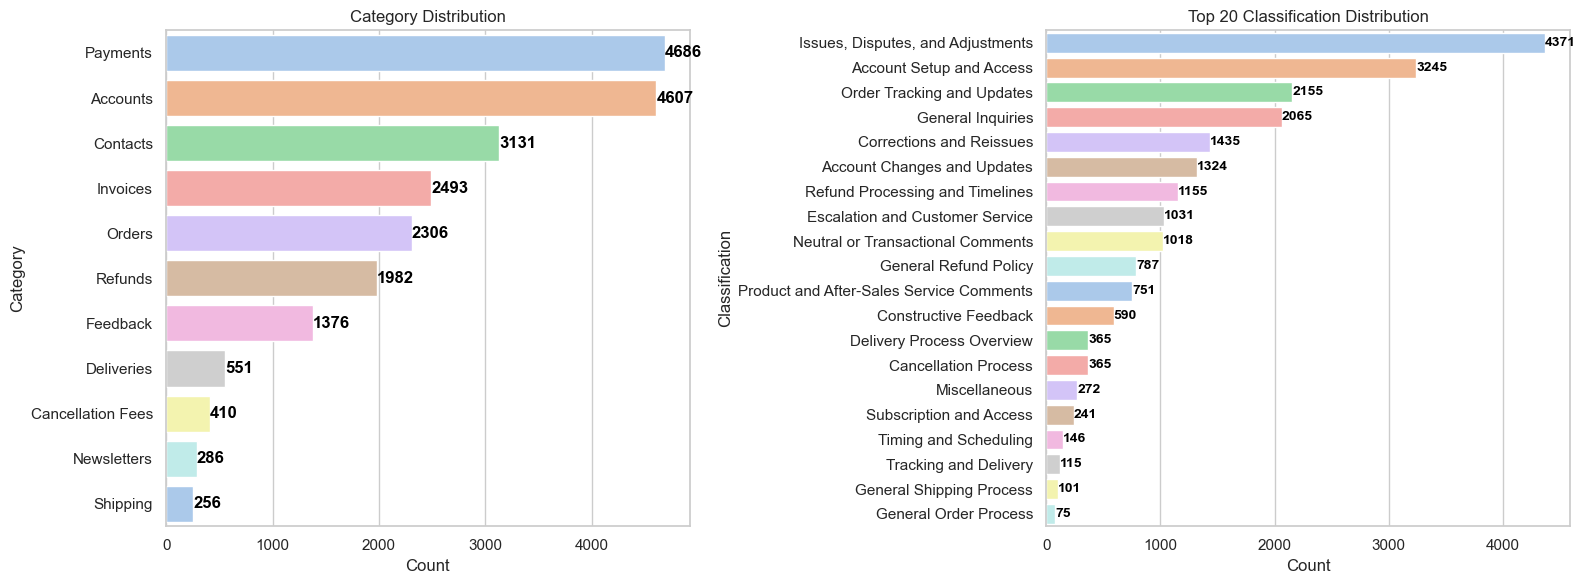

In [18]:
rs = %sql SELECT category, classification FROM chat_questions;
df = rs.DataFrame()

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot for category
category_counts = df['category'].value_counts().sort_values(ascending=False)
sns.barplot(x=category_counts.values, y=category_counts.index, ax=axes[0], palette='pastel')
axes[0].set_title('Category Distribution')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Category')

# Add count labels above the bars for category
for i, v in enumerate(category_counts.values):
    axes[0].text(v, i, str(v), color='black', va='center', ha='left', fontweight='bold')

# Bar plot for top 20 classifications
intent_counts = df['classification'].value_counts().sort_values(ascending=False).head(20)
sns.barplot(x=intent_counts.values, y=intent_counts.index, ax=axes[1], palette='pastel')
axes[1].set_title('Top 20 Classification Distribution')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Classification')

# Add count labels above the bars for intent
for i, v in enumerate(intent_counts.values):
    axes[1].text(v, i, str(v), color='black', va='center', ha='left', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


---

## SELECT statement without INDEX.

<code>
SELECT flags 
     , comment_text 
     , category 
     , classification 
     , embedding &lt;=&gt; '{}' AS "Distance" 
     , ROUND((1 - (embedding &lt;=&gt; :qry_embedding )) * 100, 2) AS "% Closeness" 
FROM chat_questions ci 
ORDER BY embedding &lt;=&gt; :qry_embedding
LIMIT 10;
</code>
<br>

In [20]:
# Use cosine similarity with no index
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

output = widgets.Output()

def on_text_change(change):
    with output:
        clear_output(wait=True)
        user_input = change['new'].strip()
        if not user_input:
            print("Please enter a query.")
            return
        
        # Generate query embedding
        qry_embedding = model.encode(user_input).tolist()
        # Format vector as CockroachDB expects: '[x1,x2,x3,...]'
        qry_embedding_str = '[' + ','.join(f'{x:.6f}' for x in qry_embedding) + ']'
        
        # Prepare SQL query with embedding parameter
        sql_qry = f"""
        SELECT comment_text
             , category
             , classification
             , embedding <=> '{qry_embedding_str}' AS "Similarity Score"
             , ROUND((1 - (embedding <=> '{qry_embedding_str}')) * 100, 2) AS "Confidence Percent"
        FROM chat_questions ci 
        ORDER BY embedding <=> '{qry_embedding_str}'
        LIMIT 10;
        """
        
        # Execute SQL query using %sql magic
        result = %sql $sql_qry
        
        # Display results
        print(f"| {'Category':>20} | {'Classification':>40} | {'Distance':^10} | {'% Closeness':^12} | {'Comment'}")
        if result:
            for row in result:
                print(f"| {row[1]:>20} | {row[2]:>40} | {row[3]:^1.4f} | {row[4]:^3.2f}% | {row[0]}")
        else:
            print("No results found.")

text_input = widgets.Text(
    value=''
  , placeholder='Enter your question here...'
  , description='Query:'
  , layout = { 'width': '800px'}
  , disabled=False
)

text_input.observe(on_text_change, names='value')

display(text_input, output)

Text(value='', description='Query:', layout=Layout(width='800px'), placeholder='Enter your question here...')

Output()

## Cockroachdb CREATE VECTOR INDEX example:

```
CREATE VECTOR INDEX ON public.chat_questions (category, embedding) WITH (min_partition_size=16, max_partition_size=128);
```

### Show the vector index is used

In [21]:
%sql SHOW INDEXES FROM chat_questions

 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
8 rows affected.


[('chat_questions', 'chat_questions_category_embedding_idx', True, 1, 'category', 'category', 'ASC', False, False, True, 1.0),
 ('chat_questions', 'chat_questions_category_embedding_idx', True, 2, 'embedding', 'embedding', 'ASC', False, False, True, 1.0),
 ('chat_questions', 'chat_questions_category_embedding_idx', True, 3, 'comment_id', 'comment_id', 'ASC', False, True, True, 1.0),
 ('chat_questions', 'chat_questions_pkey', False, 1, 'comment_id', 'comment_id', 'ASC', False, False, True, 1.0),
 ('chat_questions', 'chat_questions_pkey', False, 2, 'category', 'category', 'N/A', True, False, True, 1.0),
 ('chat_questions', 'chat_questions_pkey', False, 3, 'classification', 'classification', 'N/A', True, False, True, 1.0),
 ('chat_questions', 'chat_questions_pkey', False, 4, 'comment_text', 'comment_text', 'N/A', True, False, True, 1.0),
 ('chat_questions', 'chat_questions_pkey', False, 5, 'embedding', 'embedding', 'N/A', True, False, True, 1.0)]

### Similarity search filtering by category.

In [23]:
# Initialize embedding model
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

output_idx = widgets.Output()

def on_text_change(change):
    with output_idx:
        clear_output(wait=True)
        user_input = change['new'].strip()
        if not user_input:
            print("Please enter a query.")
            return
        
        # Generate query embedding
        qry_embedding = model.encode(user_input).tolist()
        # Format vector as CockroachDB expects: '[x1,x2,x3,...]'
        qry_embedding_str = '[' + ','.join(f'{x:.6f}' for x in qry_embedding) + ']'
        
        # Prepare SQL query with embedding parameter
        sql_qry = f"""
        SELECT comment_text
             , category
             , classification
             , embedding <=> '{qry_embedding_str}' AS "Similarity Score"
             , ROUND((1 - (embedding <=> '{qry_embedding_str}')) * 100, 2) AS "Confidence Percent"
        FROM chat_questions ci 
        WHERE category = '{txt_cat.value}'
        ORDER BY embedding <=> '{qry_embedding_str}'
        LIMIT 10;
        """
        
        # Execute SQL query using %sql magic
        result = %sql $sql_qry
        
        # Display results
        print(f"| {'Category':>20} | {'Classification':>40} | {'Distance':^10} | {'% Closeness':^12} | {'Comment'}")
        if result:
            for row in result:
                print(f"| {row[1]:>20} | {row[2]:>40} | {row[3]:^1.4f} | {row[4]:^3.2f}% | {row[0]}")
        else:
            print("No results found.")

text_input = widgets.Text(
    value=''
  , placeholder='Enter your question here...'
  , description='Query:'
  , layout = { 'width': '800px'}
  , disabled=False
)

# Create the dropdown widget
txt_cat = widgets.Dropdown(
    options=['Payments', 'Accounts', 'Contacts', 'Invoices', 'Orders', 'Refunds', 'Feedback', 'Deliveries', 'Cancellation Fees', 'Newsletters', 'Shipping']
  , description='Category:'
  , disabled=False
  , layout = { 'width': '200px'},
)
text_input.observe(on_text_change, names='value')

display(txt_cat, text_input, output_idx)

Dropdown(description='Category:', layout=Layout(width='200px'), options=('Payments', 'Accounts', 'Contacts', '…

Text(value='', description='Query:', layout=Layout(width='800px'), placeholder='Enter your question here...')

Output()

### Show the query plan

In [24]:
# Generate query plan
model = SentenceTransformer('all-MiniLM-L6-v2')

qry_embedding = model.encode(text_input.value).tolist()

# Format vector as CockroachDB expects: '[x1,x2,x3,...]'
qry_embedding_str = '[' + ', '.join(f'{x:.6f}' for x in qry_embedding) + ']'

# Extract category text
category = txt_cat.value

# Compose SQL query for EXPLAIN ANALYZE with proper formatting
sql_qry = f"""
EXPLAIN ANALYZE
SELECT comment_text
             , category
             , classification
             , embedding <-> '{qry_embedding_str}' AS "Similarity Score"
             , ROUND((1 - (embedding <=> '{qry_embedding_str}')) * 100, 2) AS "Confidence Percent"
FROM chat_questions ci 
WHERE category = '{txt_cat.value}'
ORDER BY embedding <-> '{qry_embedding_str}'
LIMIT 5;
"""

# Execute the query using %sql magic
result = %sql $sql_qry

# Display results nicely
from IPython.display import display, Markdown

# Convert result rows to a Markdown-formatted tree if available
plan_output = "\n".join(str(row[0]) for row in result)

# Display as code block for readability
display(Markdown(f"```text\n{plan_output}\n```"))


 * cockroachdb://root@localhost:26257/vectors?sslmode=disable
41 rows affected.


```text
planning time: 8ms
execution time: 50ms
distribution: local
vectorized: false
plan type: custom
rows decoded from KV: 60 (97 KiB, 1 gRPC calls)
cumulative time spent in KV: 11ms
maximum memory usage: 150 KiB
DistSQL network usage: 0 B (0 messages)
isolation level: serializable
priority: normal
quality of service: regular

• top-k
│ sql nodes: n1
│ actual row count: 5
│ estimated max memory allocated: 10 KiB
│ estimated max sql temp disk usage: 0 B
│ estimated row count: 5
│ order: +"Similarity Score"
│ k: 5
│
└── • render
    │
    └── • lookup join
        │ sql nodes: n1
        │ kv nodes: n3
        │ actual row count: 60
        │ KV time: 11ms
        │ KV rows decoded: 60
        │ KV bytes read: 97 KiB
        │ KV gRPC calls: 1
        │ estimated max memory allocated: 30 KiB
        │ table: chat_questions@chat_questions_pkey
        │ equality: (comment_id) = (comment_id)
        │ equality cols are key
        │
        └── • vector search
              table: chat_questions@chat_questions_category_embedding_idx
              target count: 5
              prefix spans: [/'Payments' - /'Payments']
```

---

<img src="./img/CockroachLabs_Logo.png">

## CockroachDB is a distributed SQL database that is __*highly scalable*__, __*resilient*__, and __*easy to use*__.

---